# Code to Test HierProb3D's PyTorch3D Rendering
For usage from within Docker container:
1. Start docker container on host with argument `-p 8888:8888`
2. From within docker:
    - Install jupyter notebook: `pip install notebook`
    - Start jupyter notebook: `jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`
3. On the host visit `localhost:8888/tree`

## Verbosity Settings
0 - silent; 1 - important only; 2 - everything

In [15]:
verbosity = 1

## Necessary Imports

In [28]:
import os
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if verbosity > 0:
    print(f"Torch {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Device: {device}")
import sys
sys.path.append('/garmentor')
from data.on_the_fly_smpl_train_dataset import OnTheFlySMPLTrainDataset
from configs import paths
from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer

Torch 1.11.0
CUDA available: True
Device: cuda:0


## Load Configuration

In [16]:
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()
if verbosity > 1:
    print(f"Configuration: \n{pose_shape_cfg}")

## Load Train and Validation Datasets and Data Loaders

In [24]:
train_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.TRAIN_POSES_PATH,
    textures_path=paths.TRAIN_TEXTURES_PATH,
    backgrounds_dir_path=paths.TRAIN_BACKGROUNDS_PATH,
    params_from='not_amass',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)

val_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.VAL_POSES_PATH,
    textures_path=paths.VAL_TEXTURES_PATH,
    backgrounds_dir_path=paths.VAL_BACKGROUNDS_PATH,
    params_from='all',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 0:
    print("Training:")
    print(f"    Poses found: {len(train_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(train_dataset.grey_textures)} / {len(train_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(train_dataset.backgrounds_paths)}")
    print("Validation:")
    print(f"    Poses found: {len(val_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(val_dataset.grey_textures)} / {len(val_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(val_dataset.backgrounds_paths)}")

Training:
    Poses found: 91106
    Textures found (gray / non-gray): 125 / 792
    Backgrounds found: 99414
Validation:
    Poses found: 33347
    Textures found (gray / non-gray): 32 / 76
    Backgrounds found: 3000


## Train and Validation Data Loaders

In [35]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Initialize PyTorch3D Renderer

In [32]:
pytorch3d_renderer = TexturedIUVRenderer(
    device=device,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE,
    projection_type='perspective',
    perspective_focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    render_rgb=True,
    bin_size=32
)

pytorch3d_textured_renderer.TexturedIUVRenderer.__init__::vertx_iuv: 
tensor([[[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.

In [42]:
for batch in train_dataloader:
    for key, val in batch.items():
        print(key)
        print(val)
    break

pose
tensor([[ 2.9039e-01, -4.3862e-01,  3.0762e+00, -1.3268e+00,  1.6109e-02,
          9.3602e-02, -1.2266e+00,  1.3607e-02, -1.0397e-01,  3.8049e-01,
         -2.3900e-02, -1.1836e-02,  1.9746e+00,  3.4955e-01, -6.2116e-01,
          2.2264e+00, -2.5547e-01,  3.1259e-01, -2.0743e-01,  4.4900e-03,
          8.9132e-02,  3.4639e-01, -3.3543e-02, -1.0456e-03,  1.4839e-01,
          2.0515e-02,  1.1765e-01, -6.5340e-03, -4.2703e-02,  1.3885e-02,
         -6.1797e-01, -6.9637e-02,  1.1928e-02, -3.7264e-01, -2.2722e-01,
         -2.2757e-01, -4.3791e-02, -3.6410e-01, -4.0946e-02,  2.5325e-01,
          2.0260e-01, -3.7430e-01,  2.5396e-01, -1.8997e-01,  2.2053e-01,
         -3.0727e-01,  3.4432e-02,  3.2237e-01,  6.5754e-01,  2.6501e-01,
         -9.2654e-01,  5.9754e-01, -4.0405e-01,  8.4244e-01,  9.0389e-01,
         -1.3863e+00, -1.6517e-01,  7.7952e-01,  1.6022e+00,  1.5386e-01,
          2.4917e-02, -2.3096e-01, -1.7008e-02, -4.4658e-01,  2.1029e-01,
          2.9079e-01, -5.7771e-01

In [45]:
batch['background'].shape

torch.Size([4, 3, 256, 256])

In [46]:
import matplotlib.pyplot as plt

Iteration 0
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,    0,    0],
        [   0,    1,    0],
        [   0,    4,    1],
        ...,
        [1199,  773,    1],
        [1199,  782,    2],
        [1199,  783,    2]])
    Background:


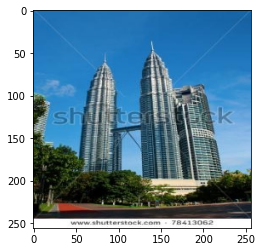

Iteration 1
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,   73,    0],
        [   0,   73,    1],
        [   0,   73,    2],
        ...,
        [1199,  765,    2],
        [1199,  766,    2],
        [1199,  767,    2]])
    Background:


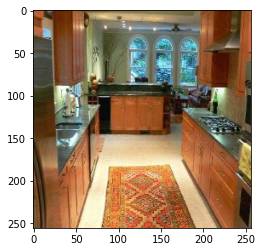

Iteration 2
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,   74,    0],
        [   0,   74,    1],
        [   0,   74,    2],
        ...,
        [1199,  775,    0],
        [1199,  782,    2],
        [1199,  783,    2]])
    Background:


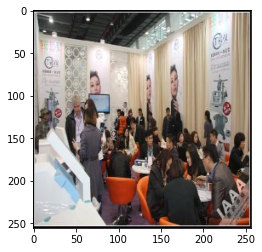

Iteration 3
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,   72,    0],
        [   0,   72,    1],
        [   0,   72,    2],
        ...,
        [1199,  769,    0],
        [1199,  770,    0],
        [1199,  771,    0]])
    Background:


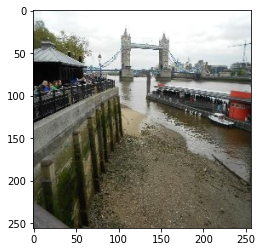

In [65]:
for i in range(len(batch)+1):
    print(f"Iteration {i}")
    print(f"    Pose: {batch['pose'][i].shape}")
    print(f"    Texture: {batch['texture'][i].shape}")
    print(f"        Non-zero: {torch.nonzero(batch['texture'][i])}")
    print(f"    Background:")
    plt.imshow(batch['background'][i].permute(1,2,0))
    plt.show()